In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from skimage.color import rgb2gray
import h5py

In [3]:
from openslide import open_slide, __library_version__ as openslide_version

# **Generating slide and mask list**

We generate our slide and mask filenames list based on the inputs.

In [4]:
# get all filenames for slides and masks not in testing
slide_filenames = ['../vatsala-adl/tumor_101.tif','../vatsala-adl/tumor_078.tif']
mask_filenames = ['../vatsala-adl/tumor_101_mask.tif','../vatsala-adl/tumor_078_mask.tif']


slide_deck = []
mask_deck = []

# slides
for filename in slide_filenames:
    slide_deck.append(open_slide(filename))

# masks
for filename in mask_filenames:
    mask_deck.append(open_slide(filename))

print(slide_deck)
print(mask_deck)

[OpenSlide('../vatsala-adl/tumor_101.tif'), OpenSlide('../vatsala-adl/tumor_078.tif')]
[OpenSlide('../vatsala-adl/tumor_101_mask.tif'), OpenSlide('../vatsala-adl/tumor_078_mask.tif')]


In [5]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [6]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


# Preprocessing and Dataset creation

The first thing we need to do is consider only those subimages which are relevant. Here, based on a threshold value, we ignore the images that mostly are just grey background. To find whether or not an image is a potential background, we calculate the tissue percentage. For this we have created a helper function that returns tissue percentage in each image

In [7]:
def find_tissue_percentage(slide_region, window_size):
    
    image_width = window_size
    image_height = window_size

    def find_tissue_pixels(image, intensity=0.8):
        im_gray = rgb2gray(image)
        assert im_gray.shape == (image.shape[0], image.shape[1])
        indices = np.where(im_gray <= intensity)
        return list(zip(indices[0], indices[1]))
    
    tissue_pixels = find_tissue_pixels(slide_region)
    percent_tissue = len(tissue_pixels) / float(image_width * image_height) * 100
    
    return percent_tissue

Below function takes a patch and detects the appropriate label for it (cancerous or not). It does so by taking sum of cancerous pixels (1 denotes cancerous). Basicaly if it finds a caancerous pixel it assigns it label one or cancerous

In [8]:
def check_if_cancer(patch_mask, patch_centre):
    # detect patch size
    patch_size = patch_mask.shape[0]
    
    # get the offset to check the x*x centre
    offset = int((patch_size-patch_centre)/2)
    
    # sum the pixels in the x*x centre for the tumor mask
    sum_cancers = np.sum(patch_mask[offset:offset+patch_centre, offset:offset+patch_centre])
    
    return sum_cancers>0

## **Exploration to see if zoomed out images corresponding**

Experiment run to see if our algorithm is zooming out correctly. Few outputs are displayed. We are zooming in and out of the center. The corresponding subimage and submask is plotted.

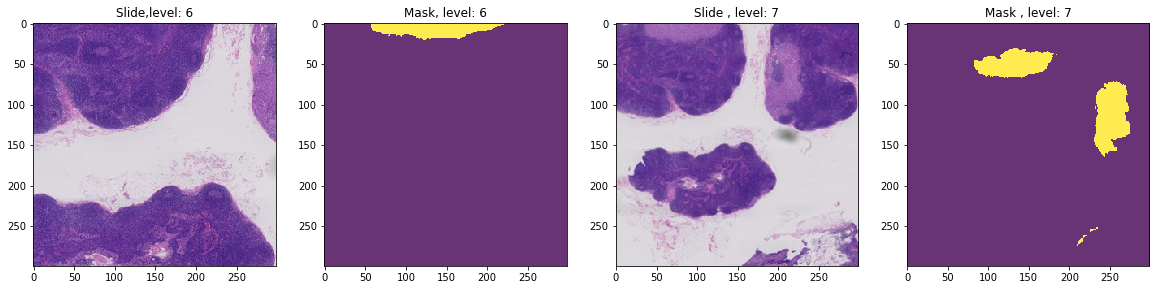

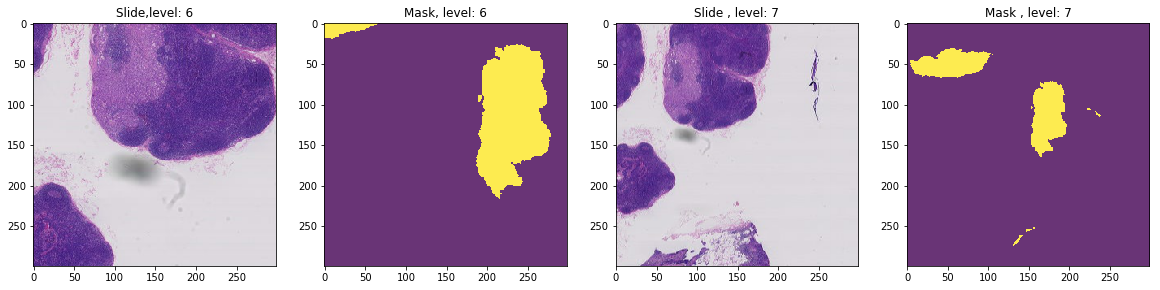

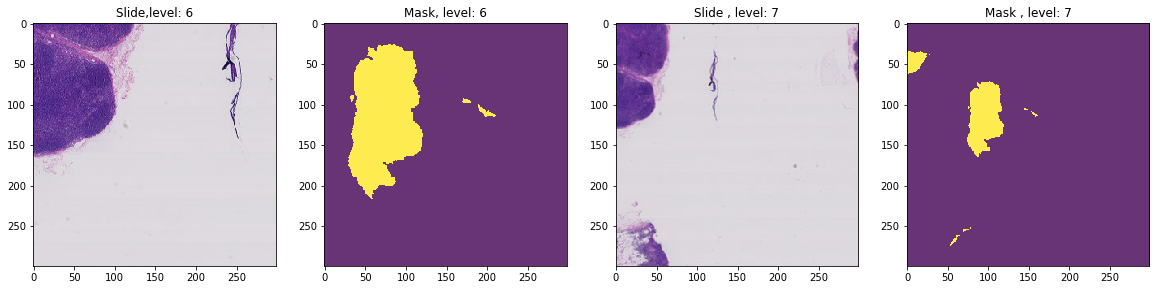

In [9]:
level_1 = 6
level_2 = 7

slide = slide_deck[0]
mask = mask_deck[0]
window_size = 299

#At slide level
image_width = slide.level_dimensions[level_1][0]
image_height = slide.level_dimensions[level_1][1]
    
x_coord = 200
y_coord = 200
downsample_factor = int(slide.level_downsamples[level_1]) #2**level
i = 0
    
# Move window through the slide
while x_coord < (image_width - window_size + 1) and i<3:
  i+=1
  

  # slide image
  slide_region = read_slide(slide, 
               x= (x_coord+(window_size//2)) * downsample_factor, 
               y= (y_coord + (window_size//2)) * downsample_factor, 
               level= level_1, 
               width= window_size, 
               height= window_size)
            
  # mask image
  mask_region = read_slide(mask, 
               x= (x_coord+(window_size//2)) * downsample_factor, 
               y= (y_coord + (window_size//2)) * downsample_factor, 
               level= level_1, 
               width= window_size, 
               height= window_size)
            
  # one channel enough for mask
  mask_region = mask_region[:,:,0]
  
  fig, axes = plt.subplots(1,4, figsize=(20,5))
  a = axes[0]
  a.imshow(slide_region)
  a.set_title('Slide,level: %d' % (level_1))
  a.grid(False)

  a = axes[1]
  a.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)
  a.set_title('Mask, level: %d' % (level_1))
  a.grid(False)
  

  # slide image
  slide_region_2 = read_slide(slide, 
               x=  x_coord* downsample_factor, 
               y=   y_coord * downsample_factor, 
               level= level_2, 
               width= window_size, 
               height= window_size)

  # mask image
  mask_region_2 = read_slide(mask, 
               x= x_coord * downsample_factor, 
               y= y_coord * downsample_factor, 
               level= level_2, 
               width= window_size, 
               height= window_size)
  mask_region_2 = mask_region_2[:,:,0]

  a = axes[2]
  a.imshow(slide_region_2)
  a.set_title('Slide , level: %d' % (level_2))
  a.grid(False)
  
  a = axes[3]
  a.imshow(mask_region_2, cmap='viridis', vmin=0, vmax=1, alpha=0.8)
  a.set_title('Mask , level: %d' % (level_2))
  a.grid(False)
  
  # move by stride
  x_coord += 200

Since our slide image is very big, we extract smaller patch images from the slide image. We decided to extract maintain separate lists of healthy and tumor images so that we could later on see what happens if we keep a balanced set.

Basically, we take a window and extract subimages with level 4 as reference. Whenever we extract a subimage from level 4 we also find its corresponding centrally zoomed out image at level 5. Both these images are appended chronologically . 
 
We also call the check_if_cancer function internally to detect label for a subimage and find_tissue_percentage to avoid computation overhead in processing majorly gray background

In [1]:
def get_patches_from_images(slide, mask, level_1, level_2, window_size, stride):
    #we are assuming here that level 1<level 2
    
    tissue_threshold = 0.01
    tumor_image_deck = []
    tumor_mask_deck = []
    tumor_mask_labels = []
    healthy_image_deck = []
    healthy_mask_deck = []
    healthy_mask_labels = []
    zoom_healthy_deck = []
    zoom_tumor_deck = []
    
    #At slide level
    image_width = slide.level_dimensions[level_1][0]
    image_height = slide.level_dimensions[level_1][1]
    
    x_val = 0
    y_val = 0
    downsample_factor = int(slide.level_downsamples[level_1]) #2**level
    patch_center = 50
    
    # Move window through the slide
    while y_val < (image_height - window_size + 1):
        
        while x_val < (image_width - window_size + 1):
            
            # slide image
            slide_region = read_slide(slide, 
                         x= (x_val+(window_size//2)) * downsample_factor, 
                         y= (y_val + (window_size//2)) * downsample_factor, 
                         level= level_1, 
                         width= window_size, 
                         height= window_size)

            # mask image
            mask_region = read_slide(mask, 
                         x= (x_val+(window_size//2)) * downsample_factor, 
                         y= (y_val + (window_size//2)) * downsample_factor, 
                         level= level_1, 
                         width= window_size, 
                         height= window_size)

            # one channel enough for mask
            mask_region = mask_region[:,:,0]
  

            # find label corresponding to the patch
            #reduced from 100 to 50 as per patch size
            cancer_present= check_if_cancer(mask_region, patch_center)
            #cancer_present = 1
            
            # ignore gray images without any tissue
            percent_tissue = find_tissue_percentage(slide_region, window_size)

            if percent_tissue > tissue_threshold:
                if cancer_present:
                    tumor_image_deck.append(slide_region)
                    tumor_mask_deck.append(mask_region)
                    tumor_mask_labels.append(1)
                else:
                    healthy_image_deck.append(slide_region)
                    healthy_mask_deck.append(mask_region)
                    healthy_mask_labels.append(0)
                    
                # slide image
                slide_region_2 = read_slide(slide, 
                             x=  x_val* downsample_factor, 
                             y=   y_val * downsample_factor, 
                             level= level_2, 
                             width= window_size, 
                             height= window_size)

                # mask image
                mask_region_2 = read_slide(mask, 
                             x= x_val * downsample_factor, 
                             y= y_val * downsample_factor, 
                             level= level_2, 
                             width= window_size, 
                             height= window_size)
                mask_region_2 = mask_region_2[:,:,0]
                
                if cancer_present:
                    zoom_tumor_deck.append(slide_region_2)
                else:
                    zoom_healthy_deck.append(slide_region_2)
                
            # move by stride
            x_val += stride
        
        # end of row, reset and move down by stride
        x_val = 0
        y_val += stride
    return tumor_image_deck, tumor_mask_labels, healthy_image_deck, healthy_mask_labels, zoom_tumor_deck, zoom_healthy_deck

In [13]:
# taken size at 150 instead of 299, as kept crashing
window_size = 150
stride = 20
level_1 = 4
level_2 = 5
# set patch sizes (I don't recomment changing that, although making it smaller 
# will decrease run time)


dataset_1_slide_subimages = []
dataset_1_slide_sublabels = []
dataset_2_slide_subimages = []
dataset_2_slide_sublabels = []

zoom_in_slide_tumor_subimages = []
#slide_tumor_submasks = []
zoom_in_slide_tumor_sublabels = []
zoom_in_slide_healthy_subimages = []
#slide_healthy_submasks = []
zoom_in_slide_healthy_sublabels = []
zoom_out_slide_tumor_subimages = []
zoom_out_slide_healthy_subimages = []


for ind in range(2):
    print(ind)
    tumor_subimages, tumor_sublabels, healthy_subimages, healthy_sublabels, zoom_tumor_deck, zoom_healthy_deck = get_patches_from_images(slide_deck[ind], mask_deck[ind], level_1, level_2, window_size, stride)
    zoom_in_slide_tumor_subimages.extend(tumor_subimages)
    zoom_in_slide_tumor_sublabels.extend(tumor_sublabels)
    zoom_in_slide_healthy_subimages.extend(healthy_subimages)
    zoom_in_slide_healthy_sublabels.extend(healthy_sublabels)
    zoom_out_slide_tumor_subimages.extend(zoom_tumor_deck)
    zoom_out_slide_healthy_subimages.extend(zoom_healthy_deck)
    

print(len(zoom_in_slide_tumor_subimages), len(zoom_in_slide_healthy_subimages))
print(len(zoom_out_slide_tumor_subimages), len(zoom_out_slide_healthy_subimages))
# slide_subimages = np.array(slide_subimages)
# slide_submasks = np.array(slide_submasks)
# slide_tumor_sublabels = np.array(slide_tumor_sublabels)

0
1
17468 126970
17468 126970


# Data Imbalance 

As we can see, the data is highly skewed. We have far more samples of healthy subimages than tumor images. To remove some of the skewness, we randomly shuffle and drop some of the healthy samples.

As we do this for one level, we will also ensure that we drop out the samples for the corresponding zoomed in/zoomed out level

In [14]:
zoom_in_slide_healthy_subimages = np.array(zoom_in_slide_healthy_subimages)
#slide_submasks = np.array(slide_submasks)
zoom_out_slide_healthy_subimages = np.array(zoom_out_slide_healthy_subimages)


n_healthy = len(zoom_in_slide_healthy_subimages)
randomize = np.arange(n_healthy)
np.random.shuffle(randomize)


zoom_in_slide_healthy_subimages = zoom_in_slide_healthy_subimages[randomize]
zoom_out_slide_healthy_subimages = zoom_out_slide_healthy_subimages[randomize]
zoom_out_slide_healthy_subimages = zoom_out_slide_healthy_subimages[1:n_healthy//2,:]
zoom_in_slide_healthy_subimages = zoom_in_slide_healthy_subimages[1:n_healthy//2,:]
zoom_in_slide_healthy_sublabels = zoom_in_slide_healthy_sublabels[1:n_healthy//2]


print(len(zoom_in_slide_tumor_subimages), len(zoom_in_slide_healthy_subimages))
print(len(zoom_out_slide_tumor_subimages), len(zoom_out_slide_healthy_subimages))
print(len(zoom_in_slide_healthy_sublabels))


17468 63484
17468 63484
63484


In [15]:
#dataset_1_slide_subimages.extend(zoom_in_slide_tumor_subimages)
#dataset_1_slide_subimages.extend(zoom_in_slide_healthy_subimages)
dataset_1_slide_sublabels = []
dataset_1_slide_sublabels.extend(zoom_in_slide_tumor_sublabels)
dataset_1_slide_sublabels.extend(zoom_in_slide_healthy_sublabels)

zoom_in_slide_tumor_subimages= np.array(zoom_in_slide_tumor_subimages)
zoom_out_slide_tumor_subimages= np.array(zoom_out_slide_tumor_subimages)
dataset_1_slide_subimages = np.vstack((zoom_in_slide_tumor_subimages,zoom_in_slide_healthy_subimages))
dataset_2_slide_subimages = np.vstack((zoom_out_slide_tumor_subimages,zoom_out_slide_healthy_subimages))

In [16]:
#dataset_1_slide_subimages = np.array(dataset_1_slide_subimages)
#slide_submasks = np.array(slide_submasks)
dataset_1_slide_sublabels = np.array(dataset_1_slide_sublabels)
#sublabels same for dataset 1 and 2!

print("Images for level 1: ", dataset_1_slide_subimages.shape)
print("Images for level 2 : ", dataset_2_slide_subimages.shape)
print("Labels: ", dataset_1_slide_sublabels.shape)

Images for level 1:  (80952, 150, 150, 3)
Images for level 2 :  (80952, 150, 150, 3)
Labels:  (80952,)


# With Data Augmentation

To further make the set balanced, we will carry out transformations on tumor images and augment the data with them. 
The basic augmentations we try are -
1. flip horizontal
2. flip vertical
3. flip horizontal and vertical 

This leads to 4x times the tumor image dataset collection!

However, we do this only if tumor images are less than a threshold

In [17]:
augmented_zoom_in = zoom_in_slide_tumor_subimages
augmented_zoom_out = zoom_out_slide_tumor_subimages
n_tumor = len(augmented_zoom_in)

if n_tumor < 16000:
    i=0
    for index in range(len(zoom_in_slide_tumor_subimages)):
      i+=1

      zoomed_in = zoom_in_slide_tumor_subimages[index]
      zoomed_out = zoom_out_slide_tumor_subimages[index]

      lr_zin = np.fliplr(zoomed_in)  
      ud_zin = np.flipud(zoomed_in)
      lrud_zin = np.flipud(lr_zin)

      lr_zout = np.fliplr(zoomed_out)  
      ud_zout = np.flipud(zoomed_out)
      lrud_zout = np.flipud(lr_zout)

      if i<=5:
        fig, axes = plt.subplots(1,4, figsize=(20,5))
        a = axes[0]
        a.imshow(zoomed_in)
        a.grid(False)
        a = axes[1]
        a.imshow(lr_zin)
        a.grid(False)
        a = axes[2]
        a.imshow(ud_zin)
        a.grid(False)
        a = axes[3]
        a.imshow(lrud_zin)
        a.grid(False)

        fig, axes = plt.subplots(1,4, figsize=(20,5))
        a = axes[0]
        a.imshow(zoomed_out)
        a.grid(False)
        a = axes[1]
        a.imshow(lr_zout)
        a.grid(False)
        a = axes[2]
        a.imshow(ud_zout)
        a.grid(False)
        a = axes[3]
        a.imshow(lrud_zout)
        a.grid(False)


      lr_zout = np.expand_dims(lr_zout,axis = 0)
      #print(lr.shape)
      ud_zout = np.expand_dims(ud_zout,axis = 0)
      #print(ud.shape)
      lrud_zout = np.expand_dims(lrud_zout,axis = 0)
      #print(lr.shape)



      ud_zin = np.expand_dims(ud_zin,axis = 0)
      #print(ud.shape)
      lrud_zin = np.expand_dims(lrud_zin,axis = 0)
      #print(lrud.shape)
      lr_zin = np.expand_dims(lr_zin,axis = 0)
      #print(lrud.shape)



      augmented_zoom_in = np.vstack((augmented_zoom_in,ud_zin))
      augmented_zoom_in = np.vstack((augmented_zoom_in,lr_zin))
      augmented_zoom_in = np.vstack((augmented_zoom_in,lrud_zin))

      augmented_zoom_out = np.vstack((augmented_zoom_out,ud_zout))
      augmented_zoom_out = np.vstack((augmented_zoom_out,lr_zout))
      augmented_zoom_out = np.vstack((augmented_zoom_out,lrud_zout))

    print("Augmented dataset ", augmented_zoom_in.shape)
    print("Augmented dataset ", augmented_zoom_out.shape)


In [18]:
n_tumor = len(augmented_zoom_in)
n_h = len(zoom_in_slide_healthy_subimages)

if((n_h+200) < n_tumor):
    n_tumor = n_h
else:
    n_h = n_tumor + 200 

augmented_zoom_in_slide_healthy_selected = zoom_in_slide_healthy_subimages[0:n_h,:]
augmented_zoom_out_slide_healthy_selected = zoom_out_slide_healthy_subimages[0:n_h,:]

randomize = np.arange(n_tumor)
np.random.shuffle(randomize)

augmented_zoom_in = augmented_zoom_in[randomize]
augmented_zoom_in = augmented_zoom_in[1:n_tumor,:]

augmented_zoom_out = augmented_zoom_out[randomize]
augmented_zoom_out = augmented_zoom_out[1:n_tumor,:]

augmented_dataset_labels = []

augmented_dataset_labels.extend([1 for i in range(len(augmented_zoom_in))])
augmented_dataset_labels.extend([0 for i in range(len(augmented_zoom_in_slide_healthy_selected))])
augmented_dataset_labels = np.array(augmented_dataset_labels)

augmented_zoom_in_final = np.vstack((augmented_zoom_in,augmented_zoom_in_slide_healthy_selected ))
augmented_zoom_out_final = np.vstack((augmented_zoom_out,augmented_zoom_out_slide_healthy_selected ))

print(augmented_zoom_in_slide_healthy_selected.shape)
print(augmented_zoom_out_slide_healthy_selected.shape)

print(augmented_zoom_in.shape)
print(augmented_zoom_out.shape)

(17668, 150, 150, 3)
(17668, 150, 150, 3)
(17467, 150, 150, 3)
(17467, 150, 150, 3)


# **Save datasets for later loading**

In [19]:
np.save('train_subimages' + str(level_1), dataset_1_slide_subimages)
np.save('train_subimages' + str(level_2), dataset_2_slide_subimages)
np.save('train_labels_shared', dataset_1_slide_sublabels)

In [20]:
np.save('train_subimages_augmented' + str(level_1), augmented_zoom_in_final)
np.save('train_subimages_augmented' + str(level_2), augmented_zoom_out_final)
np.save('train_labels_shared_augmented', augmented_dataset_labels)


print(augmented_zoom_in_final.shape)
print(augmented_zoom_out_final.shape)
print(augmented_dataset_labels.shape)

(35135, 150, 150, 3)
(35135, 150, 150, 3)
(35135,)


The augmented dataset is fairly balanced and we use that further to train a multi scale architecture